# INFO 3350/6350

## Lecture 16: Statistics, confidence intervals, and hypothesis testing

## To do

* Mini-project 3 (research report) due Thursday, 11:59pm
    * Note [Ed post about the corpus](https://edstem.org/us/courses/19463/discussion/1302770)
* Wednesday: Read articles by Underwood and by Yauney
    * Respond if it's your week
* Friday: Section as usual (HW 6 on statistical methods distributed)
* Next week (natural language processing and feature expansion)
    * Monday: HDA, ch. 7, plus linked SpaCy docs
    * Wednesday: Evans and Wilkens
    * No section meeting next week (Friday before break)

## Comparing populations (or samples)

* We often want to know whether two groups of objects differ from one another.
* Examples: British and American novels; speeches by Democratic and Republican presidents; Victorian and Modernist poems, etc.
* Trivially, yes, they are different. The groups comprise different objects.
* But nontrivially, are there specific properties for which the "average" British novel is importantly different from the "average" American novel?
    * Hypothesis: The average British novel is longer than the average American novel
    * Why? Brits are long-winded? British readers are more patient and sophisticated? Industrial conditions favoring longer texts arose earlier in the UK than in the US? Etc, etc, etc.
    
Note that we might use statistical analysis alongside feature importance measures, for example. When we find a feature that's important to a classifier, we might want to know more about how the two classes use that feature differently.

Alternatively, we might know from the start that we're interested in a certain property of our corpus and design an experiment from scratch to examine that feature.

## Example: calculate the mean length of a sample of novels from Britain and the US

In [1]:
# Get word count and number of uses of 'the' per 100k words
from   glob import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import string

# Count words in 40 novels
files = glob(os.path.join('..','data','texts', '*.txt'))
lit_data = {}
for file in files:
    name = os.path.basename(file).split('.')[0]
    nation = name.split('-')[0]
    if nation not in ['A','B']:
        pass
    else:
        with open(file, 'r') as f:
            words = f.read().lower().split()
            length = len(words)
            the_rate = np.sum([1 for word in words if word.lower().strip(string.punctuation).strip()=='the'])/length*100000
        lit_data[name] = {}
        lit_data[name]['nation'] = nation
        lit_data[name]['length'] = length
        lit_data[name]['the'] = the_rate
lit = pd.DataFrame(lit_data).T
lit['length'] = lit['length'].astype(int)
lit['the'] = lit['the'].astype(float)
display(lit.head())
display(lit.describe())

,nation,length,the
B-Wells-Time_Machine-1895-M,B,32298,6972.567961
A-Chopin-Awakening-1899-F,A,63951,5402.573846
A-Howells-Silas_Lapham-1885-M,A,128554,4234.796272
B-Forster-Room_View-1908-M,B,66421,4611.493353
A-Stowe-Uncle_Tom-1852-F,A,180604,4203.118425


,length,the
count,40.000000,40.000000
mean,131853.025000,5097.709064
std,91152.476367,1081.367366
min,14699.000000,3542.254506
25%,65803.500000,4157.093399
50%,112958.000000,5094.836289
75%,182167.750000,5902.225108
max,352395.000000,7138.810198


Feature: length


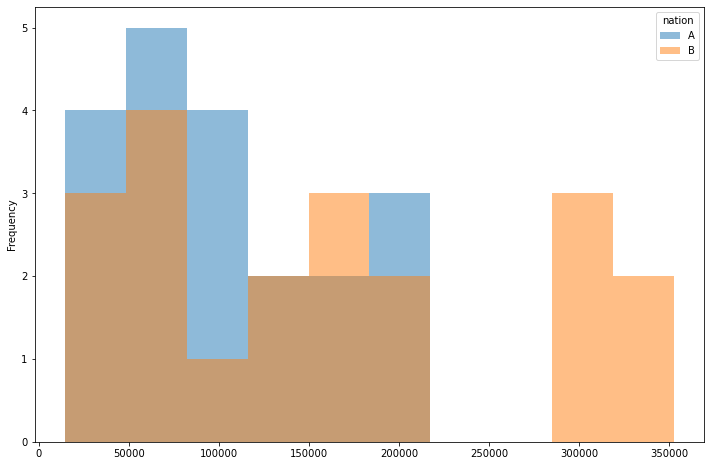

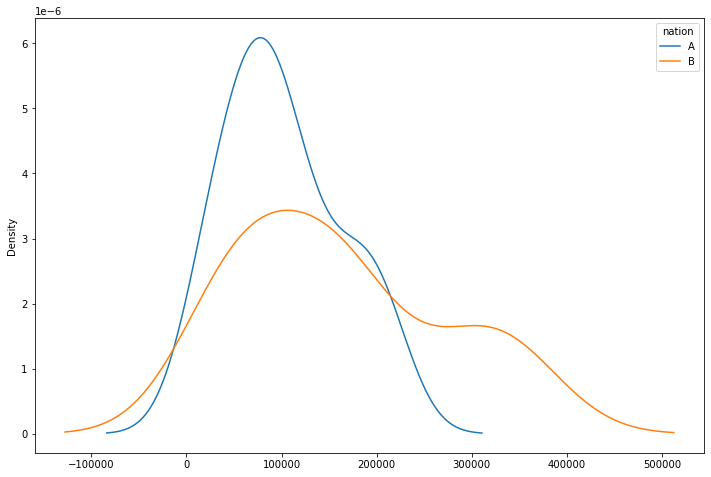


Feature: the


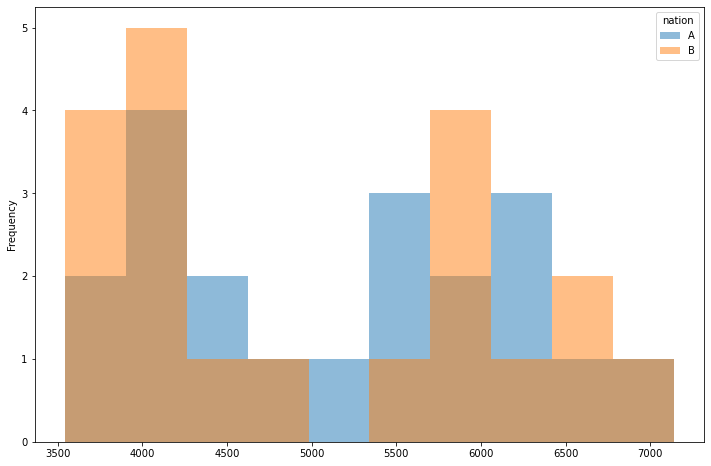

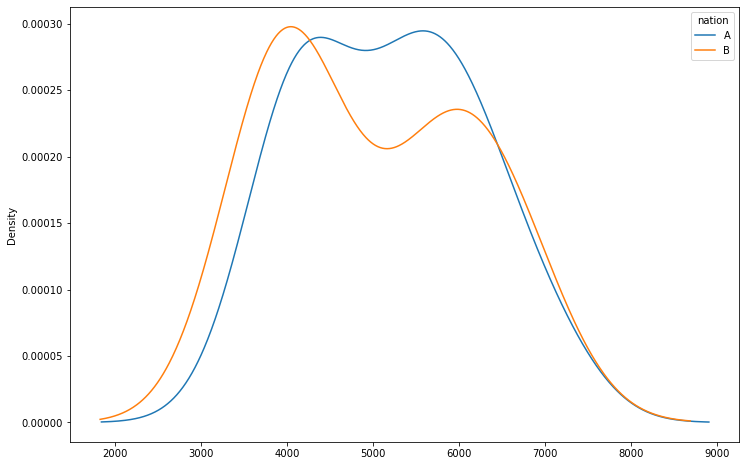

In [2]:
# Plot length distribution by nation
for feature in ['length', 'the']:
    print("Feature:", feature)
    df = lit.pivot(columns='nation', values=feature)
    df.plot.hist(figsize=(12,8), alpha=0.5)
    df.plot.density(figsize=(12,8))
    plt.show()
    print()

In [3]:
# Sample means
g = lit.groupby(['nation'])
print("Mean values")
display(g.mean().round(1))

Mean values


,length,the
nation,,
A,101755.0,5186.6
B,161951.1,5008.8


## So, British novels are longer, right?

In these two small samples, yes. But now we have two questions:

1. How **confident** should we be in this result?
1. Is the observed difference **important**?

First question first: Should we be confident that the observed difference is "real," that is, that it reflects a true difference in the means of the underlying populations, rather than an artifact of the samples we've chosen?

We could put this another way, involving a **null hypothesis**: If we assume that there is *no difference* in the length of British and American novels, what is the probability that we would nevertheless have observed a difference in their mean lengths that was as large or larger than the one we did see, simply due to random sampling? Like, maybe we just happened to pick all the long British novels and the short American ones?

**Intuition:** We should have more confidence in our results if:

* Our samples are large
* The differences *between* the samples are large
* The differences *within* each sample are small

A synthetic illustration:

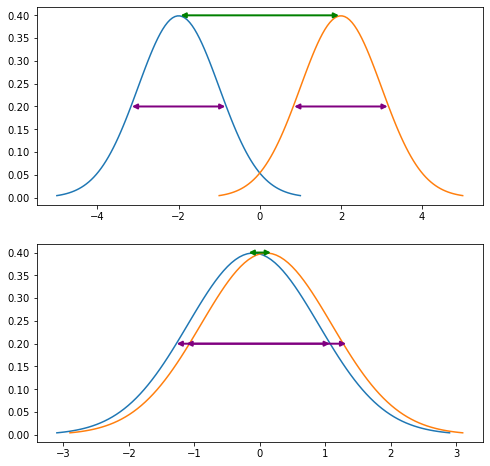

In [4]:
from scipy import stats

x1 = np.linspace(-5,1,100)
x2 = np.linspace(-1,5,100)
y1 = stats.norm.pdf(x1, -2, 1)
y2 = stats.norm.pdf(x2, 2, 1)

x3 = np.linspace(-3.1,2.9,100)
x4 = np.linspace(-2.9,3.1,100)
y3 = stats.norm.pdf(x3, -0.1, 1)
y4 = stats.norm.pdf(x4, 0.1, 1)

fig, ax = plt.subplots(2, figsize=(8,8))
ax[0].plot(x1, y1)
ax[0].plot(x2, y2)
ax[0].annotate('', xy=(-2, 0.4), xytext=(2, 0.4),
               arrowprops=dict(arrowstyle='<|-|>', color='green', lw=2)
              )
ax[0].annotate('', xy=(-3.2, 0.2), xytext=(-0.8, 0.2),
               arrowprops=dict(arrowstyle='<|-|>', color='purple', lw=2)
              )
ax[0].annotate('', xy=(0.8, 0.2), xytext=(3.2, 0.2),
               arrowprops=dict(arrowstyle='<|-|>', color='purple', lw=2)
              )

ax[1].plot(x3, y3)
ax[1].plot(x4, y4)
ax[1].annotate('', xy=(-0.2, 0.4), xytext=(0.2, 0.4),
               arrowprops=dict(arrowstyle='<|-|>', color='green', lw=2)
              )
ax[1].annotate('', xy=(-1.3, 0.2), xytext=(1.1, 0.2),
               arrowprops=dict(arrowstyle='<|-|>', color='purple', lw=2)
              )
ax[1].annotate('', xy=(-1.15, 0.2), xytext=(1.35, 0.2),
               arrowprops=dict(arrowstyle='<|-|>', color='purple', lw=2)
              )

plt.show()

Compare the distance between peaks to the width of each peak. If the distance between the peaks is much larger than the width of each peak, the observed difference between samples is likely to be real. If not, it's not.

How do these values look in our example case? Recall that we saw the distribution plots above. Here are the numbers:

In [5]:
# Sample standard deviations
print("Mean values")
display(g.mean().round(1))
print("Standard deviations")
display(g.std().round(1))

Mean values


,length,the
nation,,
A,101755.0,5186.6
B,161951.1,5008.8


Standard deviations


,length,the
nation,,
A,60124.2,1025.4
B,107390.8,1154.2


## How do we think systematically about these differences?

* Recall that, for normally distributed data, the standard deviation tells you what fraction of measurements are within a given distance from the mean
    * About 68% of points are within 1 stadard deviation ($\sigma$) of the mean; 95% within 2$\sigma$, 99.7% within 3$\sigma$
* Think of our current problem as one in which we want to know: how many standard deviations apart are the sample means?
    * If the means are more than about 2 (pooled) standard deviations apart, there's only about a 5% chance that so large a difference would arise by chance where it doesn't actually exist in the underlying populations
* This is the basis of **Student's *t*-test**
    * One of the oldest statistical hypothesis tests, first published in 1908
* We'll wave our hands about the details, especially re: pooled standard deviations, unequal variances, and unequal sample sizes
    * Note in the code below that we set `equal_var=False`, which performs a version of the *t*-test known as *Welch's t-test*, which relaxes some of the assumptions made in Student's original version

In [6]:
# Run t-tests for length and 'the'-ness btw. Brit and Amer novels
for col in ['length', 'the']:
    print(f'\n{col}:')
    result = stats.ttest_ind(
        lit.loc[lit.nation=='A'][col], 
        lit.loc[lit.nation=='B'][col],
        equal_var=False
    )
    print('t-statistic:', result[0])
    print('p-value:    ', result[1])


length:
t-statistic: -2.187309685017715
p-value:     0.03669145107609096

the:
t-statistic: 0.5150196062184773
p-value:     0.6095636121443834


## *p*-values

* A *p*-value is the probability that a result as large or larger than the observed result would have occured due to chance, given the observed distribution of the measurements (or the known characteristics of the source population(s))
* Smaller values of *p* indicate a more significant (in the statistical sense) result
* There is no *correct* value of *p* at which we should accept a result as "real" (that is, reject the null hypothesis)
* But there *is* a trade-off between false positives and false negatives
    * Set *p* too high (at 0.5 = 50%, say) and we get more false positives: we accept that two samples are "really" distinct when there's a 50% chance that the observed difference between them was due to random sampling
    * Set *p* too low (maybe at 0.001) and we get more false negatives: cases where there *is* a real difference between the classes, but we fail to acknowledge it because there is more than a 1-in-1000 chance that is was down to luck
    * Many studies set *p* = 0.05 as their significance threshold
    * But know that *nothing special happens at this level*. 
        * If you find *p* = 0.49, the difference you've found is only (very) slightly less likely to be a sampling error than a result with *p* = 0.50. 
        * Likewise, *p* = 0.50 doesn't mean that there's nothing to see in your result
        * A well-designed study considers the risks associated with false positives *and* false negatives and sets its *p* threshold accordingly
        * Better still, a careful investigator knows that a single *p*-value is just one piece of evidence in support of a hypothesis
* Note that linguistic data -- especially word counts -- are often *very* unevenly distributed across documents. It's not hard to find statistical significance in those sorts of features. Be careful!
    * And we haven't even touched multiple comparisons ...
    
![](https://imgs.xkcd.com/comics/significant.png)

Source: [xkcd](https://xkcd.com/882/)
        
Now, consider the *p*-values calculated above. Do they make sense, given what we know about the underlying distributions?
* **Yes**. Scroll back to examine the distribution plots, standard deviations, and *p*-values.

## Confidence intervals

* Sometimes we don't want or need to test a hypothesis, but we do want to take sampling effects (and random variation) into account
* Now the question is: given that I measured a mean value of *x*, what are some reasonable bounds for how much my measurement might vary if I were to take it again on a different sample drawn from the same population.
* You see something like this all the time in political polls, for example
    * The pollsters surveyed, say, 1,000 registered voters (out of more than 150,000,000 total in the US)
    * They know that the 1,000 people they ask might have different characteristics from the other 150M+ with whom they did not speak (even though they try hard to balance these things!)
    * So they estimate a "margin of error" or a "confidence interval" that indicates the range of values they would expect to find if they were to resample the population many times
    * A margin of error of 3% means that most samples would produce a result within 3 percentage points higher *or lower* than the existing result (51% +/- 3%)
    * Confidence intervals are generally reported as the actual low and high values that one would expect to find (48% to 54%)
* The confidence interval can be reported at different levels of confidence. Similar to *p* values, a 95% interval is customary.
* A confidence interval represents the range of output estimates that are not significantly different from the measured value at the *p* < *x* level.

How do you calculate a confidence interval for a set of sample results? Like so:

$$margin = t \times \frac{\sigma}{\sqrt(n)}$$

where $n$ is the sample size, $\sigma$ is the observed standard deviation, and *t* is the so-called *critical value*. For large samples, *t* is essentially the number of standard deviations from the mean necessary to reach the desired confidence level (typically about 2 for a 95% interval). For smaller samples, *t* is (a bit) larger. In any case, you can find it from a table of critical values for the *t*-distribution or via `scipy`'s `stats.t.ppf` function. Note that you need to supply the *degrees of freedom* (df) to find the critical value. Here, `df = n - 1`. (Note that the *t* distribution looks like a normal distribution for large samples, but is shorter and wider than normal for smaller samples.)

We can then calculate the actual confidence interval as the observed mean +/- the calculated margin.

In [7]:
# 95% CI for 'the'-level in Brit novels
# Calculate by hand

brit = lit.loc[lit.nation=='B']    # Select the Brit data
n = brit.the.count()               # Count data points
t = stats.t.ppf(q = 0.975, df=n-1) # Get critical value
sigma = brit.the.std()       # Calculate sample standard deviation

margin = t * sigma / np.sqrt(n)
mu = brit.the.mean() # Mean value
low = mu-margin
high = mu+margin

print("'the' count per 100,000 words in British novels:", mu, '+/-', margin)
print(f"95% confidence interval: ({mu-margin}, {mu+margin})")

'the' count per 100,000 words in British novels: 5008.810022058136 +/- 540.1889837634787
95% confidence interval: (4468.621038294657, 5548.999005821615)


In [8]:
# Calculate CI using scipy
interval = stats.t.interval(
    alpha = 0.95,
    df= n-1,
    loc = mu,
    scale = sigma/np.sqrt(n)
)
print("95% confidence interval ('the'):", interval)

95% confidence interval ('the'): (4468.621038294657, 5548.999005821615)


In [9]:
# 0.95 CI for Brit novel *length*
interval = stats.t.interval(
    alpha = 0.95,
    df= n-1,
    loc = brit.length.mean(),
    scale = brit.length.std()/np.sqrt(n)
)
print("95% confidence interval ('length'):", interval)

95% confidence interval ('length'): (111690.66340148507, 212211.53659851494)


In [10]:
# Using statsmodels
import statsmodels.stats.api as sms

sms_interval = sms.DescrStatsW(brit.length).tconfint_mean()

print(sms_interval)
sms_interval == interval

(111690.66340148507, 212211.53659851494)


True

## Bootstrapping

* Mathematical/analytical confidence intervals depend on data that is relatively normal
    * But many data sets are not normally distributed
* If you have a computer, you could just run the experiment a bunch of times and observe the *empirical* spread of the results
* This approach is called the **bootstrap method**
* Bootstrapping uses resampling *with replacement*
    * Draw from your existing objects
    * Replace the drawn object with another copy of itself
    * Repeat until you've produced a sample of the same size as the original experiment
        * Some objects will be present multiple times in the new sample (due to replacement)
        * Some objects won't be present at all
    * Repeat many times (1,000+ is typical)
    * Observe the median result (approximates the true mean) and the results at the 2.5% and 97.5% levels (lower and upper bounds of the 95% confidence interval)
* No need to assume normality or other statistical regularities

In [11]:
# Bootstrap 'the' counts in Brit novels
import random
bootstrapped_means = []
trials = 1000
k = brit.the.count() # Number of objects per sample
for i in range(trials):
    bootstrapped_means.append(np.mean(random.choices(brit.the, k=k)))

In [12]:
# How many bootstrapped results?
len(bootstrapped_means)

1000

In [13]:
# Examine a few sample means
bootstrapped_means[:5]

[4704.684999414436,
 4746.570353115486,
 4974.999891663817,
 5133.606744184084,
 4814.03679708122]

In [14]:
# Sort results
result = sorted(bootstrapped_means)

In [15]:
# Find mean and CI by inspection of bootstrap results
low = result[int(trials*0.025)]  # 2.5%
high = result[int(trials*0.975)] # 97.5%
print("Mean:", result[int(trials/2)]) # median
print("95% CI:", low, high)

Mean: 4986.603539377298
95% CI: 4545.39765876001 5480.58667282353


In [16]:
# compare analytical mean and CI
print("'the' count per 100,000 words in British novels:", mu, '+/-', margin)
print(f"95% confidence interval: ({mu-margin}, {mu+margin})")

'the' count per 100,000 words in British novels: 5008.810022058136 +/- 540.1889837634787
95% confidence interval: (4468.621038294657, 5548.999005821615)


## Importance and effect sizes

At the outset, we asked two questions:

1. Are we confident that the difference we observe between samples is *real*?
1. Is the observed difference *important*?

In colloquial use, both of these questions might use the word 'significant.' But we'll try to reserve that term for the first question (*statistical* significance) and use other words like 'importance' for the second question.

So far, we've been examining question one. What about question two (importance)?

* Importance is harder to quantify than is statistical significance, because *importance* is  contextual and interpretive
* It's very possible for a result to be statistically significant but unimportant
    * Imagine that every American author used the word 'the' exactly 5,000 times per 100,000 words and every Brit used it exactly 5,001 times per 100k
    * This result would be *significant*, but it's hard to see how it would be *important*
* Likewise, large differences in small, noisy samples might be *important* for certain purposes, even if we're not super confident about their statistical significance
    * Consider a case where false negatives are very costly, but false positives are cheap
    * Maybe a drug that's easy to make, has few side effects, and might prevent a terrible disease
    * You might administer the drug if it showed signs of effectiveness, even if the evidence didn't rise to the level of significance

We can think about **importance** by considering the **size of the observed effect**. Two common approaches to assessing effect size:

* For continuous data (linear fits, etc.), examine the correlation coefficient, *r*
    * By convention, *r* = 0.10 is a small effect, *r* = 0.30 is a medium effect, *r* = 0.50 is a large effect
    
![](https://upload.wikimedia.org/wikipedia/commons/d/d4/Correlation_examples2.svg)

[source](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient)

* For categorical cases (like the examples we've been using here), calculate *Cohen's d* as the difference in means divided by the pooled standard deviation:

$$d = \frac{\mu_1 - \mu_2}{SD_{pooled}}$$

* Again by convention, *d* = 0.20 is considered a small effect, 0.50 a medium effect, and 0.80 a large effect.
* Like the 5% significance level or 95% confidence interval, there's nothing special about these numbers. They are conventions.

In [17]:
# Calculate effect size (Cohen's d) in novel data
def cohend(d1, d2):
    pooled_std = np.sqrt(
        (len(d1)-1) * np.std(d1)**2 + (len(d2)-1) * np.std(d2)**2 / (len(d1) + len(d2) - 2)
    )
    return (np.mean(d1)-np.mean(d2))/pooled_std

In [18]:
# 'the' rate effect size
amer = lit.loc[lit.nation=='A'] # select American data (Brit selected previously)
cohend(amer.the, brit.the)

0.040149542134177686

In [19]:
# length effect size
cohend(amer.length, brit.length)

-0.2263469691059019

So, the effect size for 'the' is very small; for length, it's pretty small, but not tiny.

Note that the sign indicates the direction of the difference (which sample has the larger mean), but is otherwise irrelevant to the analysis of effect size.